---
# CVL - Get started
This is a Jupyter Notebook to get you started on a typical CVL workflow.
It provides some examples on how to
- generally format a notebook
- import data
- work with the data
- create some results in form of a visualisation

---
# Import libraries
This is how to import libraries (also called packages) which are required later in the code.

In [1]:
import os
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
import warnings
warnings.filterwarnings("ignore")

---
# Read in data

## A) Working with data products remote (supporting OPeNDAP)
NetCDF data for instance can be imported directly and we can read either the entire dataset or a subset of it. It is possible to filter by spatial and temporal dimensions.

For documentation how to work with xarray library, please visit https://xarray.pydata.org/

`open_dataset` method will open the filehandle but not read the entire contents into memory. `load_dataset` method will load the contents into memory

In [3]:
# specify dataset url (e.g. Svalbard weather station)
data_url = 'https://thredds.met.no/thredds/dodsC/met.no/observations/stations/SN99840.nc'

# reading datasets:
# decode_times option will allow to manipulate timeseries using time variable

dst = xr.open_dataset(data_url, decode_times=True)

Lets check out what is on the dataset

In [4]:
dst

<xarray.Dataset>
Dimensions:                        (time: 397152)
Coordinates:
  * time                           (time) datetime64[ns] 1975-08-01 ... 2019-...
Data variables:
    latitude                       float64 ...
    longitude                      float64 ...
    station_id                     |S64 ...
    relative_humidity              (time) float32 ...
    surface_air_pressure_2m        (time) float32 ...
    air_temperature_2m             (time) float32 ...
    wind_from_direction_10m        (time) float32 ...
    wind_speed_10m                 (time) float32 ...
    air_pressure_at_sea_level      (time) float32 ...
    air_pressure_at_sea_level_qnh  (time) float32 ...
Attributes: (12/31)
    station_name:                    SVALBARD LUFTHAVN
    wigos_identifier:                0-20000-0-01008
    wmo_identifier:                  01008
    date_created:                    2019-09-03T09:57:42.519877+00:00
    Conventions:                     ACDD-1.3,CF-1.6
    title:                           Observations from station SVALBARD LUFTH...
    ...                              ...
    time_coverage_start:             1975-08-01T00:00:00
    time_coverage_end:               2019-09-03T09:00:00
    featureType:                     timeSeries
    DODS.strlen:                     7
    DODS.dimName:                    station_id
    DODS_EXTRA.Unlimited_Dimension:  time

We want to extract air temperature and take only a subset of the dataset

In [5]:
# data subset after 1979
tmp = dst['air_temperature_2m'].where(dst['time.year']>=1979,drop=True)

# filter data
air_temperature_2m = tmp.where(tmp<300)

Create a figure and plot the extracted data

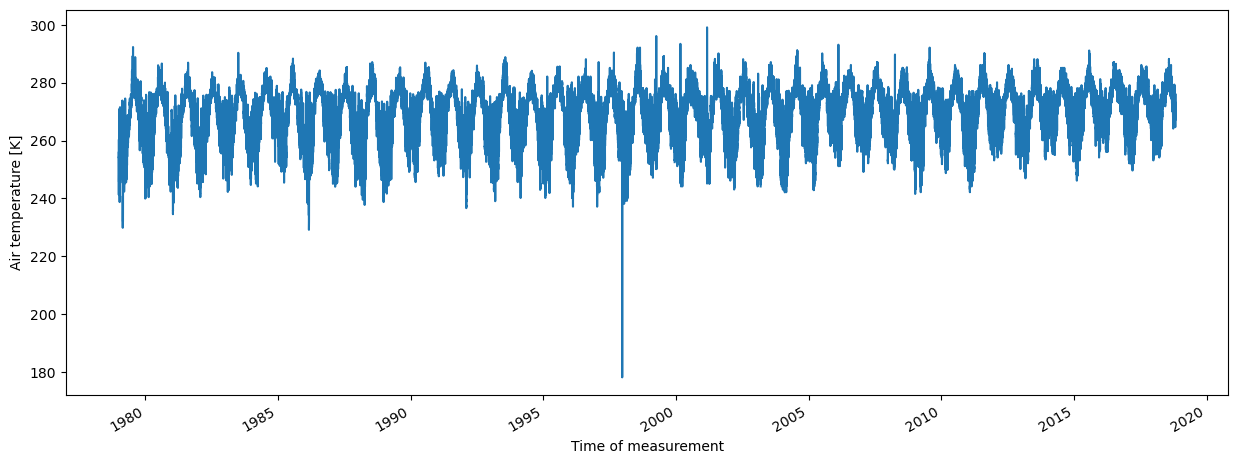

In [6]:
fig = plt.figure(figsize=(15,5))
air_temperature_2m.plot.line(x='time')

## B) Working with data products locally (not supporting OPeNDAP)
In case data can not be accessed using the OPeNDAP protocol, a local copy of the dataset is required. We will use use `requests` library to obtain the data over HTTP and `tempfile` module to remove the file after the information is extracted.

In [7]:
import requests
import tempfile

Instead of creating a permament copy of a file it is possible to load it only temporarily using `tempfile` Python module. After the data is read from the file into memory the temporary location will be automatically removed.

In [8]:
# url to data file
data_url = 'https://api.npolar.no/dataset/5f53146f-0489-4400-a94c-59a6d565bf32/_file/atw12_CTD.nc'

# create temporary directory
with tempfile.TemporaryDirectory() as tmpdirname:

    fpath = os.path.join(tmpdirname, 'tmp.nc')
    
    # create a request link to the file
    r = requests.get(data_url, allow_redirects=True)
    
    # open a NetCDF file and write the linked file into it
    open(fpath, 'wb').write(r.content)
    
    # load the dataset on to a variable
    # it will be available after the temporary directory has been deleted agian
    dst = xr.open_dataset(fpath)

From this point the steps are similar to example **A)** and you can extract a subset of the data and plot it into a figure

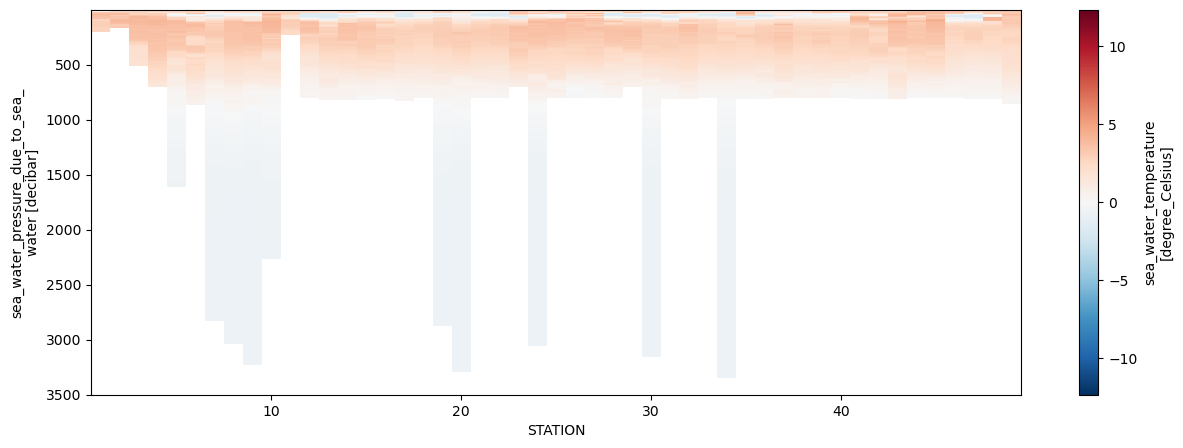

In [9]:
fig = plt.figure(figsize=(15,5))
dst['TEMP'].plot(x='STATION',y='PRES')
plt.gca().invert_yaxis()

---
# Load satellite data

Let's add satellite data to the previous plot. We will use Sentinel-2 scene from the CVL data portal served by OPeNDAP server.

In [10]:
url = "https://nbstds.met.no/thredds/dodsC/NBS/S2B/2022/09/21/S2B_MSIL1C_20220921T125739_N0400_R038_T33XVJ_20220921T150723.nc"
s2_dst = xr.open_dataset(url)
s2_dst

<xarray.Dataset>
Dimensions:                                             (time: 1, x: 10980,
                                                         y: 10980,
                                                         dimension_rgb: 3)
Coordinates:
  * time                                                (time) datetime64[ns] ...
  * x                                                   (x) int32 399960 ... ...
  * y                                                   (y) int32 8900040 ......
    lat                                                 (y, x) float32 ...
    lon                                                 (y, x) float32 ...
Dimensions without coordinates: dimension_rgb
Data variables: (12/73)
    TCI                                                 (dimension_rgb, y, x) float32 ...
    UTM_projection                                      int32 ...
    S2_Level_1C_Product_Metadata                        |S64 ...
    INSPIRE_Metadata                                    |S64 ...
    S2_Level_1C_Datastrip1_Metadata                     |S64 ...
    Format_OLQC_Report_Datastrip1_InformationData       |S64 ...
    ...                                                  ...
    view_zenith_B10                                     (time, y, x) float32 ...
    view_azimuth_B10                                    (time, y, x) float32 ...
    view_zenith_B11                                     (time, y, x) float32 ...
    view_azimuth_B11                                    (time, y, x) float32 ...
    view_zenith_B12                                     (time, y, x) float32 ...
    view_azimuth_B12                                    (time, y, x) float32 ...
Attributes: (12/84)
    DATATAKE_1_DATATAKE_SENSING_START:  2022-09-21T12:57:39.024Z
    DATATAKE_1_DATATAKE_TYPE:           INS-NOBS
    DATATAKE_1_ID:                      GS2B_20220921T125739_028950_N04.00
    DATATAKE_1_SPACECRAFT_NAME:         Sentinel-2B
    DEGRADED_ANC_DATA_PERCENTAGE:       0.0
    DEGRADED_MSI_DATA_PERCENTAGE:       0
    ...                                 ...
    geospatial_lon_min:                 9.768015990606974
    geospatial_lat_min:                 79.1449641306286
    geospatial_lon_max:                 15.51182669299969
    geospatial_lat_max:                 80.16495179276069
    DODS.strlen:                        2629
    DODS.dimName:                       dimension_SAFE_structure

# Partial loading of the dataset
By specifying how many array elements to skip we can load only Nth element for data preview.

---

In [11]:
stride = 5
ref = s2_dst["B4"][0,::stride,::stride]
lon = s2_dst['lon'][::stride,::stride]
lat = s2_dst['lat'][::stride,::stride]

---
# Create a map in custom projection

Below an example of how to create a simple map using the cartopy package and add the satellite data to it.

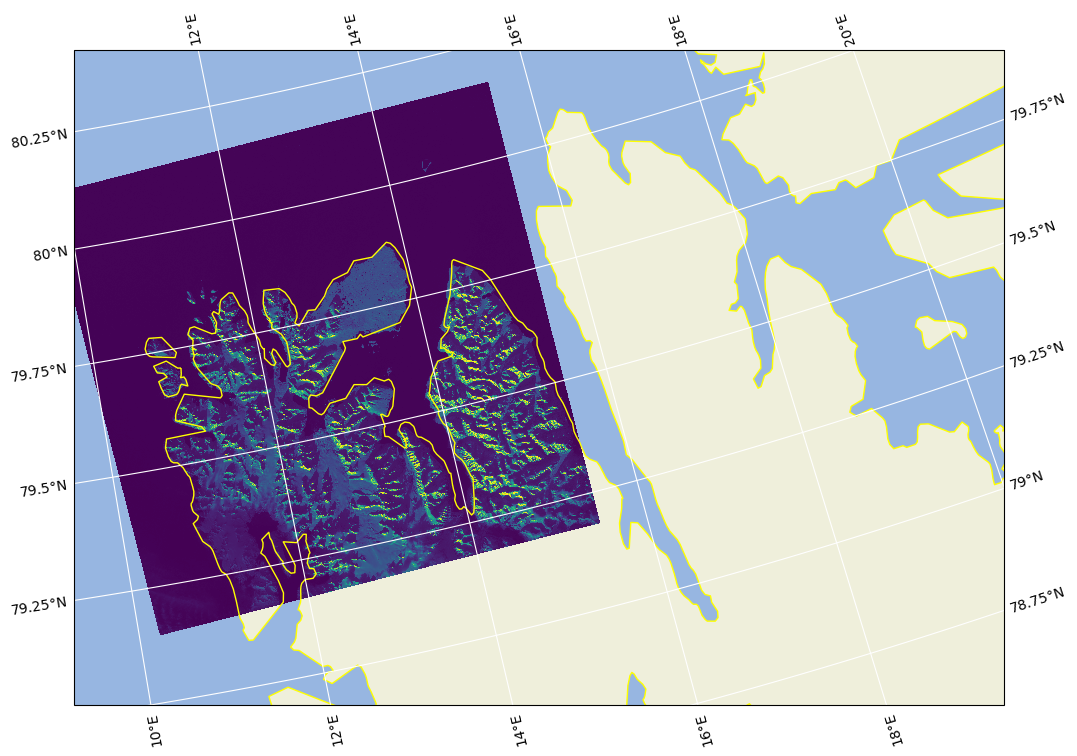

In [12]:
# define projections for the figure and the original set of coordinates
orig_projection = ccrs.PlateCarree()
target_projection = ccrs.Stereographic(central_longitude=0,central_latitude=60.)

# create a figure handle
fig = plt.figure(figsize=(12,12))

# create an axes handle with the previously specified projection
ax = plt.axes(projection=target_projection)

# customise map and add features
ax.set_extent([10,20,79,80])
plt.pcolormesh(lon, lat, ref, transform=orig_projection)

ax.gridlines(color='white',draw_labels=True, y_inline=False)
ax.coastlines(color='yellow')
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)

---
# Summary
That was it. We hope this notebook was helpful to get you started and to show an example how to format a Jupyter notebook so it can be read like a story.